In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
!pip install nltk

  Using cached nltk-3.5-py3-none-any.whl
  Using cached click-7.1.2-py2.py3-none-any.whl (82 kB)


In [5]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

Put the hyparameters at the top like this to make it easier to change and edit.

In [6]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

embedding_dim means no. of LSTM cells
OOV out of vocabalary

First, let's define two lists that containing articles and labels. In the meantime, we remove stopwords.

In [8]:
articles = []
labels = []

with open("bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


In [9]:
labels

['tech',
 'business',
 'sport',
 'sport',
 'entertainment',
 'politics',
 'politics',
 'sport',
 'sport',
 'entertainment',
 'entertainment',
 'business',
 'business',
 'politics',
 'sport',
 'business',
 'politics',
 'sport',
 'business',
 'tech',
 'tech',
 'tech',
 'sport',
 'sport',
 'tech',
 'sport',
 'entertainment',
 'tech',
 'politics',
 'entertainment',
 'politics',
 'tech',
 'entertainment',
 'entertainment',
 'business',
 'politics',
 'tech',
 'entertainment',
 'politics',
 'business',
 'politics',
 'sport',
 'business',
 'sport',
 'tech',
 'entertainment',
 'politics',
 'politics',
 'politics',
 'business',
 'sport',
 'politics',
 'business',
 'business',
 'sport',
 'politics',
 'business',
 'sport',
 'sport',
 'business',
 'business',
 'sport',
 'business',
 'sport',
 'business',
 'tech',
 'business',
 'entertainment',
 'tech',
 'business',
 'politics',
 'business',
 'politics',
 'sport',
 'business',
 'tech',
 'business',
 'sport',
 'sport',
 'business',
 'business',
 'spo

There are only 2,225 articles in the data. Then we split into training set and validation set, according to the parameter we set earlier, 80% for training, 20% for validation.

In [10]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

1780
1780
1780
445
445


Tokenizer does all the heavy lifting for us. In our articles that it was tokenizing, it will take 5,000 most common words. oov_token is to put a special value in when an unseen word is encountered. This means I want "OOV" in bracket to be used to for words that are not in the word index. "fit_on_text" will go through all the text and create dictionary like this:

In [11]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

You can see that "OOV" in bracket is number 1, "said" is number 2, "mr" is number 3, and so on.

In [9]:
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'said': 2,
 'mr': 3,
 'would': 4,
 'year': 5,
 'also': 6,
 'people': 7,
 'new': 8,
 'us': 9,
 'one': 10}

This process cleans up our text, lowercase, and remove punctuations.

After tokenization, the next step is to turn thoes tokens into lists of sequence.

In [12]:
train_sequences = tokenizer.texts_to_sequences(train_articles)

This is the 11th article in the training data that has been turned into sequences.

In [13]:
print(train_sequences[10])

[2432, 1, 225, 4994, 22, 641, 587, 225, 4994, 1, 1, 1662, 1, 1, 2432, 22, 564, 1, 1, 140, 278, 1, 140, 278, 796, 823, 662, 2308, 1, 1144, 1693, 1, 1720, 4995, 1, 1, 1, 1, 1, 4737, 1, 1, 122, 4514, 1, 2, 2874, 1505, 352, 4738, 1, 52, 341, 1, 352, 2172, 3961, 41, 22, 3795, 1, 1, 1, 1, 542, 1, 1, 1, 835, 631, 2367, 347, 4739, 1, 365, 22, 1, 787, 2368, 1, 4301, 138, 10, 1, 3665, 682, 3532, 1, 22, 1, 414, 823, 662, 1, 90, 13, 633, 1, 225, 4994, 1, 599, 1, 1693, 1021, 1, 4996, 808, 1864, 117, 1, 1, 1, 2974, 22, 1, 99, 278, 1, 1607, 4997, 542, 492, 1, 1443, 4740, 779, 1320, 1, 1861, 10, 33, 641, 319, 1, 62, 478, 564, 301, 1506, 22, 479, 1, 1, 1665, 1, 797, 1, 3067, 1, 1364, 6, 1, 2432, 564, 22, 2971, 4734, 1, 1, 1, 1, 1, 850, 39, 1825, 675, 297, 26, 979, 1, 882, 22, 361, 22, 13, 301, 1506, 1342, 374, 20, 63, 883, 1096, 4302, 247]


When we train neural networks for NLP, we need sequences to be in the same size, that's why we use padding. Our max_length is 200, so we use pad_sequences to make all of our articles the same length which is 200 in my example. That's why you see that the 1st article was 426 in length, becomes 200, the 2nd article was 192 in length, becomes 200, and so on.

In [16]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [17]:
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

425
200
192
200
186
200


In addtion, there is padding type and truncating type, there are all "post". Means for example, for the 11th article, it was 186 in length, we padded to 200, and we padded at the end, add 14 zeros.

In [14]:
print(train_sequences[10])

[2431, 1, 225, 4995, 22, 641, 587, 225, 4995, 1, 1, 1662, 1, 1, 2431, 22, 565, 1, 1, 140, 278, 1, 140, 278, 796, 823, 662, 2307, 1, 1144, 1693, 1, 1721, 4996, 1, 1, 1, 1, 1, 4738, 1, 1, 122, 4514, 1, 2, 2874, 1505, 352, 4739, 1, 52, 341, 1, 352, 2172, 3961, 41, 22, 3795, 1, 1, 1, 1, 543, 1, 1, 1, 835, 631, 2366, 347, 4740, 1, 365, 22, 1, 787, 2367, 1, 4302, 138, 10, 1, 3666, 682, 3531, 1, 22, 1, 414, 823, 662, 1, 90, 13, 633, 1, 225, 4995, 1, 599, 1, 1693, 1021, 1, 4997, 807, 1864, 117, 1, 1, 1, 2974, 22, 1, 99, 278, 1, 1608, 4998, 543, 493, 1, 1444, 4741, 778, 1320, 1, 1861, 10, 33, 641, 319, 1, 62, 479, 565, 301, 1506, 22, 480, 1, 1, 1665, 1, 797, 1, 3066, 1, 1365, 6, 1, 2431, 565, 22, 2971, 4735, 1, 1, 1, 1, 1, 850, 39, 1825, 675, 297, 26, 979, 1, 882, 22, 361, 22, 13, 301, 1506, 1343, 374, 20, 63, 883, 1096, 4303, 247]


In [18]:
print(train_padded[10])

[2432    1  225 4994   22  641  587  225 4994    1    1 1662    1    1
 2432   22  564    1    1  140  278    1  140  278  796  823  662 2308
    1 1144 1693    1 1720 4995    1    1    1    1    1 4737    1    1
  122 4514    1    2 2874 1505  352 4738    1   52  341    1  352 2172
 3961   41   22 3795    1    1    1    1  542    1    1    1  835  631
 2367  347 4739    1  365   22    1  787 2368    1 4301  138   10    1
 3665  682 3532    1   22    1  414  823  662    1   90   13  633    1
  225 4994    1  599    1 1693 1021    1 4996  808 1864  117    1    1
    1 2974   22    1   99  278    1 1607 4997  542  492    1 1443 4740
  779 1320    1 1861   10   33  641  319    1   62  478  564  301 1506
   22  479    1    1 1665    1  797    1 3067    1 1364    6    1 2432
  564   22 2971 4734    1    1    1    1    1  850   39 1825  675  297
   26  979    1  882   22  361   22   13  301 1506 1342  374   20   63
  883 1096 4302  247    0    0    0    0    0    0    0    0    0    0
    0 

And for the 1st article, it was 426 in length, we truncated to 200, and we truncated at the end.

In [19]:
print(train_sequences[0])

[91, 160, 1141, 1106, 49, 979, 755, 1, 89, 1303, 4288, 129, 175, 3653, 1213, 1194, 1576, 42, 7, 893, 91, 1, 334, 85, 20, 14, 130, 3263, 1214, 2422, 569, 451, 1375, 58, 3379, 3522, 1660, 8, 921, 730, 10, 844, 1, 9, 598, 1577, 1107, 395, 1940, 1106, 731, 49, 537, 1398, 2011, 1622, 134, 249, 113, 2356, 795, 4979, 980, 584, 10, 3956, 3957, 921, 2563, 129, 344, 175, 3653, 1, 1, 39, 62, 2867, 28, 9, 4722, 18, 1304, 136, 416, 7, 143, 1423, 71, 4501, 436, 4980, 91, 1107, 77, 1, 82, 2012, 53, 1, 91, 6, 1008, 609, 89, 1303, 91, 1963, 131, 137, 420, 9, 2868, 38, 152, 1233, 89, 1303, 4723, 7, 436, 4980, 3154, 6, 2493, 1, 431, 1126, 1, 1424, 570, 1234, 1902, 1, 766, 9, 537, 1398, 2011, 134, 2068, 400, 845, 1964, 1600, 34, 1716, 2869, 1, 1, 2423, 244, 9, 2625, 82, 732, 6, 1172, 1195, 152, 720, 591, 1, 124, 28, 1304, 1689, 432, 83, 933, 115, 20, 14, 18, 3155, 1, 37, 1484, 1, 23, 37, 87, 335, 2357, 37, 467, 255, 1964, 1358, 328, 1, 299, 732, 1173, 18, 2870, 1716, 1, 294, 756, 1074, 395, 2013, 387, 431

In [20]:
print(train_padded[0])

[  91  160 1141 1106   49  979  755    1   89 1303 4288  129  175 3653
 1213 1194 1576   42    7  893   91    1  334   85   20   14  130 3263
 1214 2422  569  451 1375   58 3379 3522 1660    8  921  730   10  844
    1    9  598 1577 1107  395 1940 1106  731   49  537 1398 2011 1622
  134  249  113 2356  795 4979  980  584   10 3956 3957  921 2563  129
  344  175 3653    1    1   39   62 2867   28    9 4722   18 1304  136
  416    7  143 1423   71 4501  436 4980   91 1107   77    1   82 2012
   53    1   91    6 1008  609   89 1303   91 1963  131  137  420    9
 2868   38  152 1233   89 1303 4723    7  436 4980 3154    6 2493    1
  431 1126    1 1424  570 1234 1902    1  766    9  537 1398 2011  134
 2068  400  845 1964 1600   34 1716 2869    1    1 2423  244    9 2625
   82  732    6 1172 1195  152  720  591    1  124   28 1304 1689  432
   83  933  115   20   14   18 3155    1   37 1484    1   23   37   87
  335 2357   37  467  255 1964 1358  328    1  299  732 1173   18 2870
 1716 

Then we do the same for the validation sequences. Note that we should expect more out of vocabulary words from validation articles because word index were derived from the training articles.

In [21]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 200)


Now we are going to look at the labels. because our labels are text, so we will tokenize them, when training, labels are expected to be numpy arrays. So we will turn list of labels into numpy arrays like so:

In [22]:
print(set(labels))

{'entertainment', 'politics', 'business', 'sport', 'tech'}


In [26]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [27]:
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


Before training deep neural network, we want to explore what our original article and article after padding look like. Running the following code, we explore the 11th article, we can see that some words become "OOV", because they did not make to the top 5,000.

In [28]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

berlin <OOV> anti nazi film german movie anti nazi <OOV> <OOV> drawn <OOV> <OOV> berlin film festival <OOV> <OOV> final days <OOV> final days member white rose movement <OOV> 21 arrested <OOV> brother hans <OOV> <OOV> <OOV> <OOV> <OOV> tyranny <OOV> <OOV> director marc <OOV> said feeling responsibility keep legacy <OOV> going must <OOV> keep ideas alive added film drew <OOV> <OOV> <OOV> <OOV> trial <OOV> <OOV> <OOV> east germany secret police discovery <OOV> behind film <OOV> worked closely <OOV> relatives including one <OOV> sisters ensure historical <OOV> film <OOV> members white rose <OOV> group first started <OOV> anti nazi <OOV> summer <OOV> arrested dropped <OOV> munich university calling day <OOV> <OOV> <OOV> regime film <OOV> six days <OOV> arrest intense trial saw <OOV> initially deny charges ended <OOV> appearance one three german films <OOV> top prize festival south african film version <OOV> <OOV> opera <OOV> shot <OOV> town <OOV> language also <OOV> berlin festival film en

Now we can implement LSTM. Here is my code that I build a tf.keras.Sequential model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices into sequences of vectors. After training, words with similar meanings often have the similar vectors.

Next is how to implement LSTM in code. The Bidirectional wrapper is used with a LSTM layer, this propagates the input forwards and backwards through the LSTM layer and then concatenates the outputs. This helps LSTM to learn long term dependencies. We then fit it to a dense neural network to do classification.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.

In [29]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 394,694
Trainable params: 394,694
Non-trainable params: 0
_________________________________________________________________


In our model summay, we have our embeddings, our Bidirectional contains LSTM, followed by two dense layers. The output from Bidirectional is 128, because it doubled what we put in LSTM. We can also stack LSTM layer but I found the results worse.

In [30]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 - 21s - loss: 1.6248 - accuracy: 0.2792 - val_loss: 1.4426 - val_accuracy: 0.3303
Epoch 2/10
1780/1780 - 14s - loss: 1.1245 - accuracy: 0.4961 - val_loss: 0.7886 - val_accuracy: 0.7101
Epoch 3/10
1780/1780 - 19s - loss: 0.4379 - accuracy: 0.8404 - val_loss: 0.3148 - val_accuracy: 0.9236
Epoch 4/10
1780/1780 - 18s - loss: 0.1059 - accuracy: 0.9775 - val_loss: 0.2929 - val_accuracy: 0.9146
Epoch 5/10
1780/1780 - 19s - loss: 0.0241 - accuracy: 0.9949 - val_loss: 0.2595 - val_accuracy: 0.9169
Epoch 6/10
1780/1780 - 19s - loss: 0.0076 - accuracy: 0.9994 - val_loss: 0.2570 - val_accuracy: 0.9281
Epoch 7/10
1780/1780 - 18s - loss: 0.0072 - accuracy: 0.9994 - val_loss: 0.3554 - val_accuracy: 0.9011
Epoch 8/10
1780/1780 - 19s - loss: 0.0146 - accuracy: 0.9978 - val_loss: 0.3218 - val_accuracy: 0.9056
Epoch 9/10
1780/1780 - 20s - loss: 0.0159 - accuracy: 0.9972 - val_loss: 0.2290 - val_accuracy: 0.9326
Epoch 10/10
1780/1780 - 19

In [42]:
!pip install matplotlib

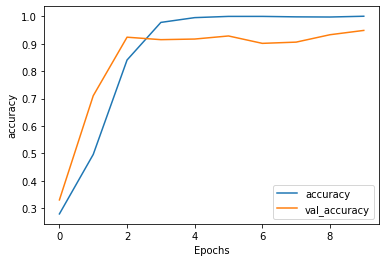

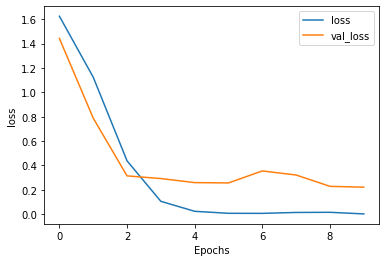

In [32]:
from matplotlib import pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Testing Model

In [33]:
txt = ["A WeWork shareholder has taken the company to court over the near-$1.7bn (£1.3bn) leaving package approved for ousted co-founder Adam Neumann."]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
pred

array([[1.5726439e-06, 1.6261397e-03, 3.2351338e-05, 1.6969739e-07,
        1.0564421e-05, 9.9832922e-01]], dtype=float32)

In [34]:
txt = ["A WeWork shareholder has taken the company to court over the near-$1.7bn (£1.3bn) leaving package approved for ousted co-founder Adam Neumann."]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment','unknown']
print(pred, labels[np.argmax(pred)])

[[1.5726439e-06 1.6261397e-03 3.2351338e-05 1.6969739e-07 1.0564421e-05
  9.9832922e-01]] unknown


In [35]:
np.argmax(pred)

5

In [37]:
txt = ["games maker fights for survival one of britain s largest independent game makers  argonaut games  has been put up for sale.  the london-based company behind the harry potter games has sacked about 100 employees due to a severe cash crisis. the administrators told bbc news online that selling argonaut was the only way to save it as it had run out of cash. argonaut warned that it was low on cash 10 days ago when its shares were suspended from trading on the london stock exchange.  argonaut has been making games for some 18 years and is one the largest independent games developers in the uk.  along with its headquarters in north london  it operates studios in cambridge and sheffield. argonaut was behind the harry potter games which provided a healthy flow of cash into the company. but  like all software developers  argonaut needed a constant flow of deals with publishers. signs that it was in trouble emerged in august  when it warned it was heading for losses of Â£6m in the financial year due to delays in signing new contracts for games. those new deals were further delayed  leading argonaut to warn in mid-october that it was running out of cash and suspend trading of its shares on the london stock exchange. as part of cost-cutting measures  some 100 employees were fired.  when the news about the Â£6m loss came out  we knew there were going to be redundancies   said jason parkinson  one of the game developers sacked by argonaut.  a lot of people suspected that argonaut had been in trouble for some time   he told bbc news online. mr parkinson said staff were told the job losses were necessary to save argonaut from going under. at the start of the year  the company employed 268 people. after the latest round of cuts there are 80 staff at argonaut headquarters in edgware in north london  with 17 at its morpheme offices in kentish town  london  and 22 at the just add monsters base in cambridge.  argonaut called in administrators david rubin & partners on friday to find a way to rescue the company from collapse. it spent the weekend going over the company s finances and concluded that the only way to save the business was to put it up for sale. the administrator told bbc news online that the costs of restructuing would be too high  partly because of the overheads from the company s four premises across the uk. it said it was hopeful that it could save some 110 jobs by selling the business  saying it had had expressions of interest from several quarters and were looking for a quick sale. the administrator said it would ensure that staff made redundant would receive any wages  redundancy or holiday pay due to them  hopefully by christmas."]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment','unknown']
print(pred, labels[np.argmax(pred)])


[[0.00138938 0.02058147 0.36977506 0.01942592 0.49385867 0.09496955]] entertainment


model is overfitted here as validation accuracy is fluctuating
even on increasing epochs validation accuracy is not getting better

Try using different model architecture use stacked LSTM with dropout layer to reduce overfitting

In [38]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.LSTM(embedding_dim ,return_sequences=True),
    tf.keras.layers.LSTM(32,return_sequences=True),
    tf.keras.layers.LSTM(32,return_sequences=True),
    tf.keras.layers.LSTM(32,return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32,return_sequences=True),
    tf.keras.layers.LSTM(32,return_sequences=True),
    tf.keras.layers.LSTM(32,return_sequences=True),
    tf.keras.layers.LSTM(32),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          12416     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 32)         

In [39]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 1780 samples, validate on 445 samples
Epoch 1/10
1780/1780 - 93s - loss: 1.6738 - accuracy: 0.2045 - val_loss: 1.6110 - val_accuracy: 0.2270
Epoch 2/10
1780/1780 - 83s - loss: 1.6126 - accuracy: 0.2281 - val_loss: 1.6082 - val_accuracy: 0.2270
Epoch 3/10
1780/1780 - 76s - loss: 1.6110 - accuracy: 0.2124 - val_loss: 1.6023 - val_accuracy: 0.2270
Epoch 4/10
1780/1780 - 78s - loss: 1.6090 - accuracy: 0.2197 - val_loss: 1.6042 - val_accuracy: 0.2382
Epoch 5/10
1780/1780 - 74s - loss: 1.6096 - accuracy: 0.2202 - val_loss: 1.6094 - val_accuracy: 0.2270
Epoch 6/10
1780/1780 - 71s - loss: 1.6095 - accuracy: 0.2399 - val_loss: 1.6030 - val_accuracy: 0.2382
Epoch 7/10
1780/1780 - 93s - loss: 1.6084 - accuracy: 0.2208 - val_loss: 1.6060 - val_accuracy: 0.2270
Epoch 8/10
1780/1780 - 86s - loss: 1.6119 - accuracy: 0.2225 - val_loss: 1.6053 - val_accuracy: 0.2382
Epoch 9/10
1780/1780 - 86s - loss: 1.6131 - accuracy: 0.2230 - val_loss: 1.6181 - val_accuracy: 0.2270
Epoch 10/10
1780/1780 - 79

To visualize model architecture save model as model.h5
and can be visualize in Netron 

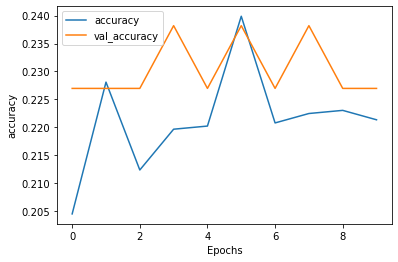

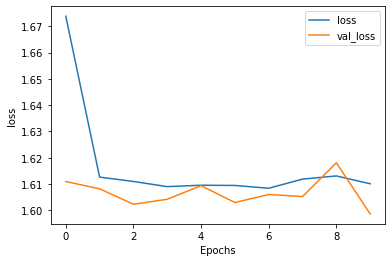

In [41]:
from matplotlib import pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Stacking LSTM layers here make our model worse as evident from accuracy plots